# 🦒 Fine-tuning Cellpose with BioEngine ⚙️☁️

## Installation and module imports

In [1]:
try:
    # For pyodide in the browser
    import micropip

    await micropip.install(["pyodide-http", "hypha-rpc", "httpx", "kaibu-utils", "matplotlib", "tifffile", "numpy==1.26.4"])

    # 2. Patch requests
    import pyodide_http

    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess

    subprocess.call(["pip", "install", "hypha-rpc", "httpx", "kaibu-utils", "matplotlib", "tifffile", "numpy==1.26.4"])

import zipfile
from pathlib import Path

import httpx
import matplotlib.pyplot as plt
import numpy as np
from hypha_rpc import connect_to_server, login
from tifffile import imread

  Using cached kaibu_utils-0.1.14-py3-none-any.whl.metadata (3.1 kB)
  Using cached geojson-3.2.0-py3-none-any.whl.metadata (16 kB)
  Using cached pyodide_http-0.2.2-py3-none-any.whl.metadata (372 bytes)
Using cached kaibu_utils-0.1.14-py3-none-any.whl (7.5 kB)
Using cached geojson-3.2.0-py3-none-any.whl (15 kB)
Using cached pyodide_http-0.2.2-py3-none-any.whl (9.8 kB)


In [2]:
# Server URL: For this demo we will use the hypha.aicell.io server
SERVER_URL = "https://hypha.aicell.io"

### Connect to the server

In [ ]:
token = await login({"server_url": SERVER_URL})

server = await connect_to_server(
    {"server_url": SERVER_URL, "token": token}
)
workspace = server.config.workspace

print(f"Connected to workspace: {workspace}")

artifact_manager = await server.get_service("public/artifact-manager")

Please open your browser and login at https://hypha.aicell.io/public/apps/hypha-login/?key=34nRgEtxPRmdqvazTE7Xm8
Connected to workspace: ws-user-github|478667


ERROR:websocket-client:Failed to connect to wss://hypha.aicell.io/ws
ERROR:websocket-client:Failed to connect to wss://hypha.aicell.io/ws: timed out during opening handshake
ERROR:RPC:Failed to register service built-in: RemoteError:Traceback (most recent call last):
             ^^^^^^^^^^^^
  File "/opt/venv/lib/python3.11/site-packages/hypha_rpc/utils/schema.py", line 471, in wrapper
    ret = await original_func(*new_args, **new_kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hypha/core/workspace.py", line 2040, in register_service
    peer_service = ServiceInfo.from_redis_dict(peer_service)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hypha/core/__init__.py", line 174, in from_redis_dict
    return cls.model_validate(converted_data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hypha/core/__init__.py", line 181, in model_validate
    return super().model_validate(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^


### Access the BioEngine deployments

A public BioEngine instance is available with the service ID `bioimage-io/bioengine-apps`

In [ ]:
PUBLIC_BIOENGINE = "bioimage-io/bioengine-apps"

bioengine = await server.get_service(PUBLIC_BIOENGINE)

If you have started your own BioEngine instance, you can first list your deployment services and then 

In [ ]:
services = await server.list_services({"type": "bioengine-apps"})

for service in services:
    print(f"BioEngine apps service ID: {service.id}")
    PRIVATE_BIOENGINE = service.id

if len(services) == 0:
    print(f"No BioEngine apps service available in workspace '{server.config.workspace}'.")

bioengine = await server.get_service(PRIVATE_BIOENGINE)

BioEngine apps service ID: ws-user-github|49943582/CzPYgNED8t85WgTwWA2uHz:bioengine-apps


### Visualize some collected data

In [ ]:
data_dir = "/data/nmechtel/bioengine-worker/data/hpa_demo"

In [ ]:
data_dir = Path(data_dir)
annotations_dir = data_dir / "annotations"

# List to hold pairs of image and corresponding annotation masks
image_annotation_pairs = []

# Get list of all images and annotations
annotation_files = list(annotations_dir.glob("*.tif"))

# Iterate through each annotation file
for annotation_file in annotation_files:
    annotation_name = annotation_file.name
    image_name = annotation_name.split("_mask_")[0]
    image_file = data_dir / f"{image_name}.tif"

    image_annotation_pairs.append((image_file, annotation_file))


# Print the number of annotations
print(f"Number of annotations: {len(image_annotation_pairs)}")

Number of annotations: 6


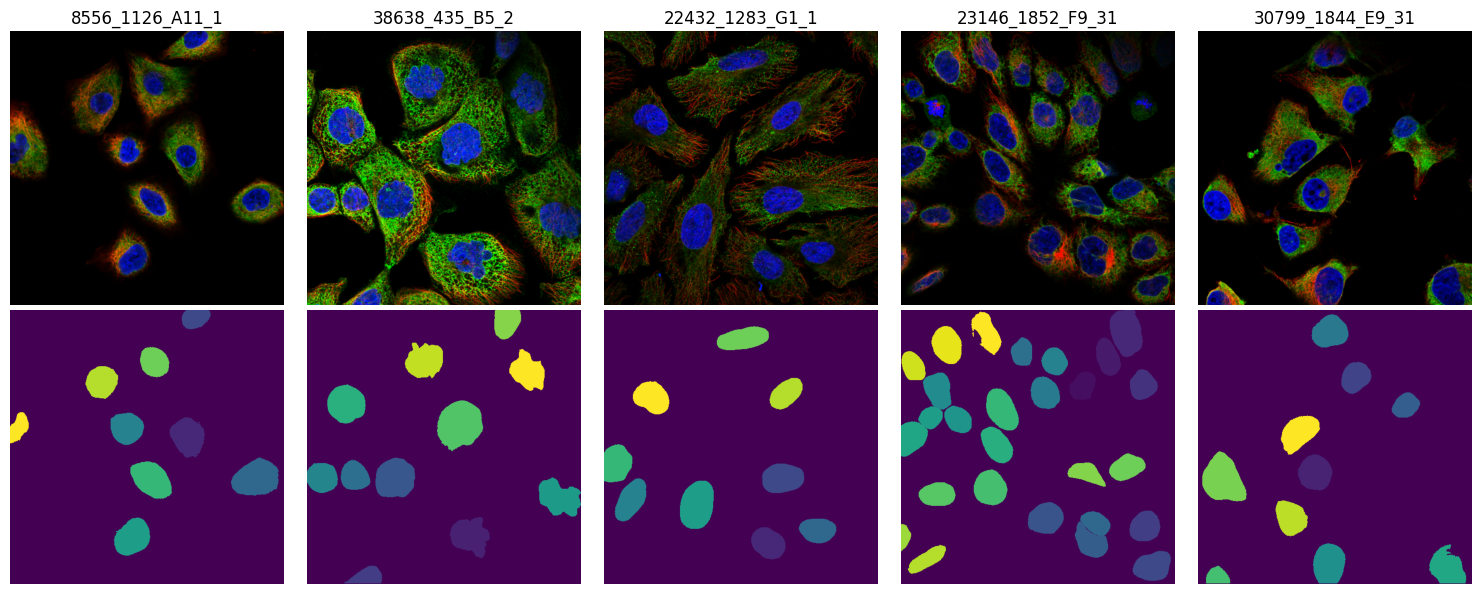

In [ ]:
assert len(image_annotation_pairs) >= 5

# Plot several random annotations
choices = np.random.choice(len(image_annotation_pairs), 5, replace=False)
plt.figure(figsize=(15, 6))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    img = imread(image_annotation_pairs[choices[i]][0])
    plt.imshow(img.transpose(1, 2, 0))
    plt.title(f"{image_annotation_pairs[choices[i]][0].stem}")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    mask = imread(image_annotation_pairs[choices[i]][1])
    plt.imshow(mask)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Upload the annotated dataset to the collection

First, create the BioImage.IO Colab collection (if not already created)

In [ ]:
# Check if the data collection exists
collection_id = f"{workspace}/bioimageio-colab"

try:
    await artifact_manager.read(collection_id)
except Exception as e:
    expected_error = f'KeyError: "Artifact with ID \'{collection_id}\' does not exist."'
    if str(e).strip().endswith(expected_error):
        print(f"Collection '{collection_id}' does not exist. Creating it.")

    collection_manifest = {
        "name": "BioImage.IO Colab",
        "description": "A collection of annotated images from BioImage.IO Colab and fine-tuned models.",
    }
    collection = await artifact_manager.create(
        alias=collection_id,
        type="collection",
        manifest=collection_manifest,
        config={"permissions": {"*": "r", "@": "r+"}}
    )
    print(f"BioImage.IO Colab data collection created with ID: {collection.id}")

Upload the annotated dataset to the BioImage.IO Colab collection

In [ ]:
# Create a zip file of the image_annotation_pairs
data_path = data_dir / "data.zip"
with zipfile.ZipFile(data_path, 'w') as zipf:
    for img_file, mask_file in image_annotation_pairs:
        zipf.write(img_file, img_file.relative_to(data_dir))
        zipf.write(mask_file, mask_file.relative_to(data_dir))

In [ ]:
with zipfile.ZipFile(data_path, 'r') as zipf:
    zipf.extractall(data_dir)

In [ ]:
# Create a zip file of the image_annotation_pairs
data_path = data_dir / "data.zip"
with zipfile.ZipFile(data_path, 'w') as zipf:
    for img_file, mask_file in image_annotation_pairs:
        zipf.write(img_file, img_file.relative_to(data_dir))
        zipf.write(mask_file, mask_file.relative_to(data_dir))


# Load the dataset content
dataset_content = data_path.read_bytes()

# Create or update the dataset artifact
dataset_manifest = {
    "name": "HPA Demo",
    "description": "An annotated dataset for Cellpose finetuning",
    "type": "data",
}
data_artifact_alias = "hpa-demo"

try:
    # Edit the existing deployment and stage it for review
    artifact = await artifact_manager.edit(
        artifact_id=f"{workspace}/{data_artifact_alias}",
        manifest=dataset_manifest,
        type=dataset_manifest["type"],
        stage=True,
    )
except:
    # If the artifact does not exist, create it
    artifact = await artifact_manager.create(
        alias=data_artifact_alias,
        parent_id=collection_id,
        manifest=dataset_manifest,
        type=dataset_manifest["type"],
        stage=True,
    )
    print(f"Artifact created with ID: {artifact.id}")

# Upload manifest.yaml
manifest_url = await artifact_manager.put_file(artifact.id, file_path="manifest.yaml")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(manifest_url, data=dataset_manifest)
    response.raise_for_status()
    print(f"Uploaded manifest.yaml to artifact")

# Upload the dataset content as a zip file
data_url = await artifact_manager.put_file(artifact.id, file_path="data.zip")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(data_url, data=dataset_content)
    response.raise_for_status()
    print(f"Uploaded data.zip to artifact")

# Commit the artifact
await artifact_manager.commit(artifact_id=artifact.id)
print(f"Committed artifact with ID: {artifact.id}")

Uploaded manifest.yaml to artifact
Uploaded data.zip to artifact
Committed artifact with ID: ws-user-github|49943582/hpa-demo


### Choose a pre-trained model to fine-tune

**Note:** Cellpose 4.0.7 only supports the `cpsam` (Cellpose-SAM) model. This is a transformer-based segmentation model that is channel-order invariant and provides better performance than previous versions.

In [ ]:
pretrained_models = await bioengine.bioimage_io_cellpose_finetuning.list_pretrained_models()

print("Available pretrained models: \n -", '\n - '.join(pretrained_models))

Available pretrained models: 
 - cyto
 - cyto3
 - nuclei
 - tissuenet_cp3
 - livecell_cp3
 - yeast_PhC_cp3
 - yeast_BF_cp3
 - bact_phase_cp3
 - bact_fluor_cp3
 - deepbacs_cp3


Here we choose the `cellpose` model `cpsam` (Cellpose-SAM 4.0) for segmentation.

**Note:** Cellpose 4.0.7 only supports the `cpsam` model, which is a transformer-based model that is channel-order invariant.

In [ ]:
initial_model = "cpsam"

### Prepare the data for training

Create an artifact for the fine-tuned Cellpose model

In [ ]:
model_manifest = {
    "name": "Finetuned Cellpose model",
    "description": f"Finetuned model for Cellpose {initial_model}",
    "type": "model",
}
model_artifact_alias = f"cellpose-{initial_model}-hpa-finetuned"
finetuning_result = model_artifact_alias.replace("-", "_") + ".zip"

try:
    model_artifact = await artifact_manager.create(
        alias=model_artifact_alias,
        parent_id=collection_id,
        manifest=model_manifest,
        type=model_manifest["type"],
        stage=True,
    )
    print(f"Artifact created with ID: {model_artifact.id}")
except:
    artifact_id = f"{workspace}/{model_artifact_alias}"
    artifact_files = await artifact_manager.list_files(artifact_id)
    for file in artifact_files:
        if file.name == finetuning_result:
            print(f"The file '{finetuning_result}' already exists in the artifact '{artifact_id}'. Overwriting it.")
            break

    # Edit the existing artifact with the new manifest
    model_artifact = await artifact_manager.edit(
        artifact_id=f"{workspace}/{model_artifact_alias}",
        manifest=model_manifest,
        type=model_manifest["type"],
        stage=True,
    )

# Create presigned URLs for data download and model upload
data_download_url = await artifact_manager.get_file(
    artifact_id=f"{workspace}/{data_artifact_alias}", file_path="data.zip"
)

model_upload_url = await artifact_manager.put_file(
    model_artifact.id, file_path=finetuning_result
)

data = {
    "data_download_url": data_download_url,
    "result_upload_url": model_upload_url,
    "initial_model": initial_model,
}

The file 'cellpose_cyto3_hpa_finetuned.zip' already exists in the artifact 'ws-user-github|49943582/cellpose-cyto3-hpa-finetuned'. Overwriting it.


### Run the Cellpose fine-tuning with Real-Time Progress Tracking

The async API allows you to start training and monitor its progress with comprehensive real-time updates. 

**Key Features:**
- **Real-time epoch tracking**: See current epoch, total epochs, and progress
- **Training metrics**: Monitor training and test losses as they update
- **Dataset information**: View training/test sample counts immediately
- **Timing information**: Track elapsed time and training start time
- **Path-based file matching**: Use wildcard patterns to match image/annotation files

**Parameters:**
- `artifact`: Your training dataset artifact ID
- `train_images`: Path pattern for training images (e.g., "*.tif", "images/*.ome.tif")
- `train_annotations`: Path pattern for annotations (e.g., "annotations/*_mask.tif")
- `test_images`, `test_annotations`: Optional test set patterns
- `model`: Pretrained model to start from (default: "cpsam")
- `n_epochs`: Number of training epochs
- `n_samples`: Optional - limit number of samples to use

**The API will:**
1. Start training asynchronously and return a session ID
2. Provide real-time status updates via `get_training_status(session_id)`
3. Track comprehensive metrics: losses, timing, dataset info, epoch progress
4. When complete, use the session ID as the model parameter for inference

**Enhanced Status Information:**
The status now includes: `status_type`, `message`, `train_losses`, `test_losses`, `n_train`, `n_test`, `start_time`, `current_epoch`, `total_epochs`, and `elapsed_seconds` - giving you complete visibility into training progress!

In [ ]:
# Start the Cellpose fine-tuning asynchronously
import asyncio

# Get the cellpose service
cellpose_service = await server.get_service("bioimage-io/cellpose-finetuning")

# Start training with the new path-based API
session_status = await cellpose_service.start_training(
    artifact=f"{workspace}/{data_artifact_alias}",
    train_images="*.tif",  # Pattern for image files
    train_annotations="annotations/*_mask*.tif",  # Pattern for annotation files
    model=initial_model,
    n_epochs=10,
    n_samples=None,  # Use all available samples
    min_train_masks=1,  # Minimum masks per image
)

session_id = session_status["session_id"]
print(f"Training session started with ID: {session_id}")
print("\nMonitoring training progress with real-time updates...\n")

# Monitor training progress with enhanced status
while True:
    status = await cellpose_service.get_training_status(session_id)
    
    # Build comprehensive progress message
    msg = f"[{status['status_type']}] {status['message']}"
    
    # Add dataset info if available
    if "n_train" in status:
        msg += f" | Train: {status['n_train']} samples"
    if "n_test" in status and status.get('n_test', 0) > 0:
        msg += f", Test: {status['n_test']} samples"
    
    # Add epoch progress if available
    if "current_epoch" in status and "total_epochs" in status:
        msg += f" | Epoch: {status['current_epoch']}/{status['total_epochs']}"
    
    # Add elapsed time if available
    if "elapsed_seconds" in status:
        msg += f" | Time: {status['elapsed_seconds']:.1f}s"
    
    # Add latest training loss if available
    if "train_losses" in status and status["train_losses"]:
        losses = [l for l in status["train_losses"] if l > 0]
        if losses:
            msg += f" | Train Loss: {losses[-1]:.4f}"
    
    print(f"\r{msg}", end="", flush=True)
    
    if status["status_type"] in ("completed", "failed"):
        print("\n")  # New line after completion
        break
    
    await asyncio.sleep(2)

if status["status_type"] == "failed":
    raise RuntimeError(f"Training failed: {status['message']}")

# Print final summary
print("=" * 80)
print("Training Completed Successfully!")
print("=" * 80)
print(f"Fine-tuned model ID: {session_id}")

if "train_losses" in status:
    valid_losses = [l for l in status["train_losses"] if l > 0]
    if valid_losses:
        print(f"Initial loss: {valid_losses[0]:.4f}")
        print(f"Final loss: {valid_losses[-1]:.4f}")
        print(f"Loss improvement: {((valid_losses[0] - valid_losses[-1]) / valid_losses[0] * 100):.1f}%")

### Test the fine-tuned model

Now let's test the fine-tuned model by running inference on a sample image.

In [ ]:
# Run inference with the fine-tuned model
test_image_path = str(image_annotation_pairs[0][0].relative_to(data_dir))

inference_result = await cellpose_service.infer(
    model=session_id,  # Use the fine-tuned model
    artifact=f"{workspace}/{data_artifact_alias}",
    diameter=40,
    image_paths=[test_image_path],
)

print(f"Inference completed!")
print(f"Result shape: {inference_result[0]['output'].shape}")

In [ ]:
# Visualize the inference result
import matplotlib.pyplot as plt

# Load the original image and annotation
test_img = imread(image_annotation_pairs[0][0])
test_annotation = imread(image_annotation_pairs[0][1])
predicted_mask = inference_result[0]['output']

plt.figure(figsize=(15, 5))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(test_img.transpose(1, 2, 0))
plt.title("Original Image")
plt.axis("off")

# Plot predicted mask from fine-tuned model
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask)
plt.title(f"Predicted Mask\\n(Fine-tuned {initial_model})")
plt.axis("off")

# Plot ground truth annotation
plt.subplot(1, 3, 3)
plt.imshow(test_annotation)
plt.title("Ground Truth Annotation")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Compare with pretrained model
pretrained_result = await cellpose_service.infer(
    model=initial_model,  # Use the pretrained model
    artifact=f"{workspace}/{data_artifact_alias}",
    diameter=40,
    image_paths=[test_image_path],
)

pretrained_mask = pretrained_result[0]['output']

plt.figure(figsize=(15, 5))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(test_img.transpose(1, 2, 0))
plt.title("Original Image")
plt.axis("off")

# Plot predicted mask from pretrained model
plt.subplot(1, 3, 2)
plt.imshow(pretrained_mask)
plt.title(f"Pretrained {initial_model}")
plt.axis("off")

# Plot predicted mask from fine-tuned model
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask)
plt.title(f"Fine-tuned {initial_model}")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"\\nComparison complete!")
print(f"You can see how the fine-tuned model performs compared to the pretrained model.")

In [ ]:
# Additional notes about the API

print("""
### Cellpose Fine-Tuning API Summary (with Real-Time Progress Tracking)

The async API provides the following methods:

1. start_training() - Start asynchronous fine-tuning
   Parameters:
   - artifact: Artifact ID containing training data
   - train_images: Path pattern for training images (e.g., "*.tif" or "images/*.ome.tif")
   - train_annotations: Path pattern for annotations (e.g., "annotations/*_mask.tif")
   - test_images: Optional test images path pattern
   - test_annotations: Optional test annotations path pattern
   - model: Pretrained model to start from (default: "cpsam")
   - n_epochs: Number of training epochs
   - n_samples: Number of samples to use (optional)
   - learning_rate, weight_decay: Training hyperparameters
   
2. get_training_status(session_id) - Monitor training progress with real-time updates
   Returns comprehensive status dict with:
   - status_type: "waiting", "preparing", "running", "completed", or "failed"
   - message: Human-readable status message
   - train_losses: Per-epoch training loss values (updated in real-time)
   - test_losses: Per-epoch test loss values (computed periodically)
   - n_train: Number of training samples
   - n_test: Number of test samples
   - start_time: Training start time (ISO 8601 format)
   - current_epoch: Current epoch number (1-indexed)
   - total_epochs: Total number of epochs
   - elapsed_seconds: Elapsed time since training started
   
3. infer() - Run inference with a model
   Parameters:
   - model: Model ID (session_id for fine-tuned, or "cpsam" for pretrained)
   - artifact: Artifact ID containing images
   - image_paths: List of image paths within the artifact
   - diameter: Expected cell diameter (optional, auto-detected if None)
   - flow_threshold: Flow error threshold (default: 0.4)
   - cellprob_threshold: Cell probability threshold (default: 0.0)
   - niter: Number of iterations for dynamics (default: None, auto-set)
   
4. list_pretrained_models() - Get available pretrained models
   
### Key Features:
- Real-time progress tracking with epoch-by-epoch updates
- Comprehensive training metrics including losses, timing, and dataset info
- Path-based training API with wildcard patterns for flexible file matching
- Cellpose-SAM is channel-order invariant - no need to specify channel order
- Automatically uses first 3 channels of your image
- For best results, use flow_threshold=0.4, cellprob_threshold=0, niter=250
""")